In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet      #useful for xml operations
from sklearn.model_selection import train_test_split

In [2]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 2


In [3]:
!pip install ultralytics       #for yolo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 724.5 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.0/793.0 kB 6.2 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install -U ipywidgets      #to get widgets appearing on kernel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.6 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [5]:
dataset_path = '/kaggle/input/car-plate-detection'        

In [6]:
import re

def the_number_in_the_string(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(0)) if match else 0


labels_dict = dict(img_path=[], xmin=[], xmax=[], ymin=[], ymax=[], img_w=[], img_h=[])

xml_files = glob(f'{dataset_path}/annotations/*.xml')
for filename in sorted(xml_files, key=the_number_in_the_string):
    info = xet.parse(filename)
    root = info.getroot()
    
    
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    
    img_name = xet.parse(filename).getroot().find('filename').text
    img_path = os.path.join(dataset_path, 'images',img_name)

    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
    height, width, _ = cv2.imread(img_path).shape      #r,g,b
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
alldata = pd.DataFrame(labels_dict)
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


In [20]:
train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
      {len(train) = }
      {len(val) = }
      {len(test) = }
''')


      len(train) = 345
      len(val) = 44
      len(test) = 44



In [21]:
if os.path.exists('datasets'):
    shutil.rmtree('datasets')
#convert image in yolo format
def make_split_folder_in_yolo_format(split_name, split_df):
    labels_path = os.path.join('datasets', 'cars_license_plate', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate', split_name, 'images')

    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))  #imgname,png
        
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")    #.4 decimal is size
            
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"created '{images_path}' and '{labels_path}'")
    
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

created 'datasets/cars_license_plate/train/images' and 'datasets/cars_license_plate/train/labels'
created 'datasets/cars_license_plate/val/images' and 'datasets/cars_license_plate/val/labels'
created 'datasets/cars_license_plate/test/images' and 'datasets/cars_license_plate/test/labels'


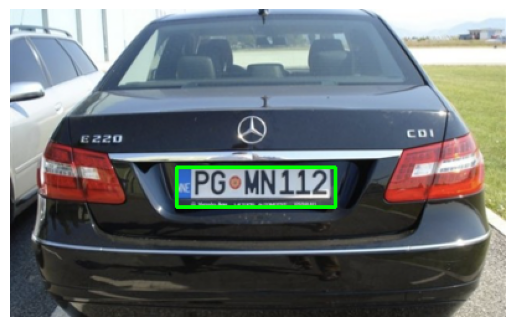

In [22]:
'''
Plot the first train image and its bounding box.
'''

# Directory paths
image_dir = 'datasets/cars_license_plate/train/images'
label_dir = 'datasets/cars_license_plate/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box
plt.imshow(image)
plt.axis('off')
plt.show()

In [23]:
datasets_yaml = '''
path: cars_license_plate

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [24]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

In [25]:
model.train(
    data='datasets.yaml',
    epochs=100,
    batch=16,
    device='cuda',
    imgsz=320,
    cache=True,
)

Ultralytics YOLOv8.2.41 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

train: Scanning /kaggle/working/datasets/cars_license_plate/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 482.50it/s]


train: New cache created: /kaggle/working/datasets/cars_license_plate/train/labels.cache


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 193.03it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/cars_license_plate/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 461.55it/s]


val: New cache created: /kaggle/working/datasets/cars_license_plate/val/labels.cache


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 192.68it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.11G      1.771      2.942      1.344         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.24it/s]


                   all         44         44    0.00367      0.909      0.483      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.17G      1.486      1.484      1.123         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]

                   all         44         44       0.02      0.614      0.357      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.18G      1.465      1.331      1.139         16        320: 100%|██████████| 22/22 [00:01<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]


                   all         44         44          1     0.0817      0.143     0.0781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.19G      1.483      1.285      1.161         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.34it/s]


                   all         44         44      0.163      0.182      0.124     0.0629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.19G      1.436      1.218      1.159         16        320: 100%|██████████| 22/22 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.92it/s]


                   all         44         44       0.77      0.591      0.676      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.18G      1.457      1.149      1.158         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.34it/s]


                   all         44         44      0.705      0.682      0.708      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.19G      1.496      1.138      1.167         10        320: 100%|██████████| 22/22 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.66it/s]


                   all         44         44      0.695      0.614      0.682      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.18G      1.456      1.093       1.13         14        320: 100%|██████████| 22/22 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.21it/s]


                   all         44         44      0.718      0.753      0.763      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.19G      1.339      1.043      1.112         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.91it/s]

                   all         44         44       0.89      0.841       0.87      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.18G      1.403      1.003      1.133         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


                   all         44         44      0.871      0.864      0.871      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.19G       1.42      1.002      1.143         19        320: 100%|██████████| 22/22 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


                   all         44         44      0.902      0.773      0.841      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.18G      1.408      1.016      1.134         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


                   all         44         44      0.733      0.841      0.775      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.19G      1.357      0.954      1.116         21        320: 100%|██████████| 22/22 [00:01<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.61it/s]


                   all         44         44      0.743      0.841      0.776      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.18G      1.302      0.897      1.095         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]

                   all         44         44      0.845       0.87      0.896      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.19G      1.271     0.8815      1.066         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.11it/s]

                   all         44         44      0.898       0.75      0.852      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.18G      1.324     0.9245      1.113         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.34it/s]

                   all         44         44      0.773      0.682      0.773      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.19G      1.315     0.8696      1.109         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]

                   all         44         44      0.892      0.841      0.917      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.18G      1.371     0.8768      1.123         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.60it/s]

                   all         44         44      0.874      0.864      0.882      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.19G      1.255       0.83      1.067         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]

                   all         44         44      0.757      0.918      0.852       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.18G      1.233     0.8193      1.086         16        320: 100%|██████████| 22/22 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.95it/s]

                   all         44         44      0.797      0.841      0.843      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.19G       1.22     0.7984       1.06         19        320: 100%|██████████| 22/22 [00:01<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.35it/s]

                   all         44         44      0.908      0.892      0.863      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.18G       1.23     0.7862      1.059         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.06it/s]


                   all         44         44      0.852      0.932      0.904      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.19G      1.172      0.768      1.051         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.96it/s]

                   all         44         44       0.87      0.932       0.91      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.18G      1.139      0.724      1.027         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.85it/s]

                   all         44         44      0.823      0.909      0.893      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.19G      1.136     0.7292      1.027         26        320: 100%|██████████| 22/22 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.28it/s]


                   all         44         44      0.964      0.886      0.937      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.18G      1.195      0.731      1.055         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.52it/s]

                   all         44         44      0.899      0.864       0.88       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.19G      1.197     0.7483      1.035         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.97it/s]

                   all         44         44      0.905      0.864      0.924      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.18G      1.183      0.731       1.03         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.82it/s]

                   all         44         44       0.89      0.955      0.931      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.19G      1.178     0.7142      1.035         21        320: 100%|██████████| 22/22 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.79it/s]

                   all         44         44      0.927      0.932      0.941      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.18G       1.13     0.6944      1.031         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.80it/s]

                   all         44         44      0.866      0.909      0.937      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.19G      1.151     0.6871      1.033         12        320: 100%|██████████| 22/22 [00:01<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.88it/s]

                   all         44         44      0.871      0.923      0.912      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.18G      1.127     0.6868      1.017         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.21it/s]

                   all         44         44      0.835      0.932      0.909      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.19G       1.05     0.6625       1.01         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.54it/s]


                   all         44         44      0.847      0.909      0.895       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.18G      1.098     0.6705      1.038         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.67it/s]

                   all         44         44       0.86      0.886      0.896       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.19G      1.083      0.658      1.013         14        320: 100%|██████████| 22/22 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


                   all         44         44      0.874      0.864      0.908      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.18G      1.088     0.6702      1.011         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.40it/s]

                   all         44         44      0.912      0.864      0.887      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.19G      1.096     0.6585     0.9992         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.04it/s]

                   all         44         44      0.927      0.862      0.874      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.18G      1.018     0.6381     0.9723         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.94it/s]

                   all         44         44      0.879      0.886      0.889      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.19G      1.056     0.6414      1.007         11        320: 100%|██████████| 22/22 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.69it/s]

                   all         44         44      0.904      0.886      0.899      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.18G      1.035     0.6307     0.9819         19        320: 100%|██████████| 22/22 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.09it/s]

                   all         44         44      0.905      0.861        0.9      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.19G      1.045     0.6404     0.9766         16        320: 100%|██████████| 22/22 [00:01<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.69it/s]

                   all         44         44      0.925       0.84      0.886      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.18G      1.047     0.6401     0.9801         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.28it/s]


                   all         44         44      0.869      0.795      0.823      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.19G      1.008     0.6247     0.9955         14        320: 100%|██████████| 22/22 [00:01<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


                   all         44         44      0.898      0.801      0.852      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.18G     0.9906        0.6     0.9729         12        320: 100%|██████████| 22/22 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.61it/s]

                   all         44         44      0.921      0.841      0.887      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.19G      1.001     0.6027       0.98         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.30it/s]

                   all         44         44      0.843      0.864      0.908      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.18G     0.9911     0.5942     0.9642         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.44it/s]

                   all         44         44      0.937      0.818      0.907      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.19G     0.9888     0.5999     0.9651         14        320: 100%|██████████| 22/22 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.16it/s]

                   all         44         44      0.891      0.886       0.93      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.18G     0.9735     0.6037     0.9849         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.49it/s]

                   all         44         44      0.863      0.932       0.92      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.19G     0.9874     0.5891      0.997         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.90it/s]

                   all         44         44      0.879      0.864      0.911      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.18G     0.9612     0.5959     0.9672         25        320: 100%|██████████| 22/22 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.98it/s]

                   all         44         44      0.908      0.898       0.96      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.19G     0.9764       0.59     0.9561         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.30it/s]

                   all         44         44      0.926      0.859      0.924      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.18G     0.9464     0.5747     0.9738         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.82it/s]

                   all         44         44      0.872      0.932      0.943      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.19G     0.9773     0.5749     0.9584         11        320: 100%|██████████| 22/22 [00:01<00:00, 12.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]


                   all         44         44      0.844      0.909      0.911       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.18G     0.9776     0.5879     0.9574         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.22it/s]

                   all         44         44      0.917      0.841      0.924      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.19G     0.9482     0.5666     0.9656         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.21it/s]


                   all         44         44      0.922      0.864      0.947      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.18G     0.9164     0.5468     0.9511         19        320: 100%|██████████| 22/22 [00:01<00:00, 12.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.81it/s]

                   all         44         44      0.883      0.864       0.92      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.19G     0.9033     0.5644     0.9619         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.30it/s]

                   all         44         44      0.928       0.88      0.924      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.18G      0.889     0.5504     0.9585         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


                   all         44         44      0.951      0.878      0.934      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.19G     0.9428     0.5426     0.9504         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.12it/s]

                   all         44         44      0.909      0.907      0.948      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.18G     0.9163     0.5408     0.9485         21        320: 100%|██████████| 22/22 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.31it/s]

                   all         44         44      0.928      0.877      0.913      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.19G     0.8997     0.5484     0.9463         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.47it/s]

                   all         44         44      0.906      0.879      0.902      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.18G     0.9007     0.5353     0.9437         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.46it/s]

                   all         44         44      0.949      0.864      0.934      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.19G     0.8841      0.531     0.9385         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.33it/s]

                   all         44         44      0.887      0.932      0.939      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.18G     0.8564      0.537     0.9407         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.01it/s]

                   all         44         44      0.881      0.886      0.902      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.19G     0.9027     0.5551     0.9562         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.84it/s]

                   all         44         44      0.907      0.909      0.914      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.18G     0.8777     0.5286     0.9613         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.91it/s]

                   all         44         44      0.903      0.843      0.935      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.19G     0.8574     0.5144     0.9355         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.95it/s]

                   all         44         44      0.814      0.909      0.907      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.18G     0.8838       0.54     0.9405         14        320: 100%|██████████| 22/22 [00:01<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


                   all         44         44      0.844      0.859      0.899      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.19G     0.8469      0.509     0.9256         18        320: 100%|██████████| 22/22 [00:01<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.86it/s]

                   all         44         44      0.918      0.818      0.891      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.18G     0.8415     0.5062     0.9474         22        320: 100%|██████████| 22/22 [00:02<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]


                   all         44         44      0.902      0.836      0.906      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.19G     0.8349     0.4946     0.9154         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.83it/s]

                   all         44         44       0.88      0.864      0.916      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.18G     0.8505     0.5105     0.9444         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.91it/s]

                   all         44         44      0.886      0.882      0.906      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.19G     0.8719     0.5432     0.9345         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.74it/s]

                   all         44         44      0.923      0.821      0.931      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.18G     0.8787     0.5125     0.9231         15        320: 100%|██████████| 22/22 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.15it/s]


                   all         44         44      0.904      0.852       0.92        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.19G     0.8289     0.4946     0.9291         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.84it/s]

                   all         44         44      0.847       0.88      0.905      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.18G     0.7811     0.4753     0.9099         20        320: 100%|██████████| 22/22 [00:01<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.31it/s]

                   all         44         44      0.935      0.864      0.921      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.19G     0.7975     0.4783     0.9109         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.17it/s]

                   all         44         44      0.832      0.902      0.936      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.18G     0.8016       0.48     0.9098         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]

                   all         44         44      0.793      0.909      0.912      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.19G     0.8217     0.4792     0.9239         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.10it/s]

                   all         44         44      0.865      0.886      0.937      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.18G     0.7756     0.4626     0.9098         22        320: 100%|██████████| 22/22 [00:01<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.07it/s]

                   all         44         44      0.881      0.839      0.902        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.19G     0.8222     0.4695     0.9325         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]

                   all         44         44       0.86      0.838      0.906      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.18G     0.8312     0.4782     0.9315         16        320: 100%|██████████| 22/22 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.34it/s]

                   all         44         44      0.862      0.864      0.902      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.19G     0.7896     0.4775     0.9165         22        320: 100%|██████████| 22/22 [00:01<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.13it/s]

                   all         44         44      0.812      0.909      0.905      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.18G     0.7529      0.453     0.8982         26        320: 100%|██████████| 22/22 [00:01<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.67it/s]

                   all         44         44      0.862      0.852      0.913      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.19G     0.7519     0.4517     0.9082         24        320: 100%|██████████| 22/22 [00:01<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.10it/s]

                   all         44         44       0.84      0.864      0.906      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.18G     0.7614     0.4519     0.9211         26        320: 100%|██████████| 22/22 [00:01<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.33it/s]

                   all         44         44      0.869      0.904      0.945      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.19G     0.7878     0.4684     0.9145         13        320: 100%|██████████| 22/22 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.61it/s]


                   all         44         44      0.867      0.909      0.946      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.18G     0.7774     0.4653     0.9143         17        320: 100%|██████████| 22/22 [00:01<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.67it/s]

                   all         44         44      0.868      0.898       0.95      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.19G      0.784     0.4591     0.9057         16        320: 100%|██████████| 22/22 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.62it/s]

                   all         44         44      0.888      0.901      0.948      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.18G     0.7353     0.4499     0.9083         12        320: 100%|██████████| 22/22 [00:01<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.16it/s]

                   all         44         44       0.88      0.886      0.936      0.512


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.19G     0.9989     0.5394      1.012          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

                   all         44         44       0.88      0.886      0.928      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.18G     0.9959     0.5359     0.9966          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.28it/s]

                   all         44         44      0.905      0.886      0.938      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.19G     0.9668     0.4977     0.9931          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.46it/s]

                   all         44         44      0.888        0.9      0.919      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.18G     0.9608     0.4973      1.003          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.81it/s]

                   all         44         44      0.883      0.909      0.922      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.19G     0.9318     0.4896     0.9907          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all         44         44       0.94      0.841      0.919      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.18G     0.9249     0.4889     0.9805          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]

                   all         44         44      0.947      0.808      0.921      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.19G     0.9359     0.4757     0.9794          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.28it/s]

                   all         44         44      0.868      0.909       0.92      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.18G      0.928     0.4868     0.9688          8        320: 100%|██████████| 22/22 [00:01<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.57it/s]

                   all         44         44      0.848      0.909      0.929       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.19G     0.8857     0.4775     0.9842          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.17it/s]

                   all         44         44      0.849      0.909      0.928      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.18G     0.9269     0.4787     0.9722          9        320: 100%|██████████| 22/22 [00:01<00:00, 12.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.93it/s]

                   all         44         44      0.845      0.909       0.93      0.528



100 epochs completed in 0.081 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.41 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


                   all         44         44      0.883      0.864      0.921      0.542
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train3


lr/pg0,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▇▇▇██▇▇▇▇▇▇█▇▇█▇▇█████████▇████████████
metrics/mAP50-95(B),▁▆▇█▇█▇▇███▇▇▇▇▇▇▇█████▇▇▇██▇▇██▇▇██▇███
metrics/precision(B),▆▂▄▅▅▄▅▇▇▂▅▃▄▄▇▆▇▇█▅▇▇▅▆▆▅▁▇▅▆▂▄▄▄▄▅▆▅▄▅
metrics/recall(B),▁▇▇███▇▇▇▇▇███▇█▇▇▇▇▇▇▇████▇█▇██▇▇█████▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▄▃▃▃▃▃▃▂▂▂▂▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▂▂▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7821f41f06a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

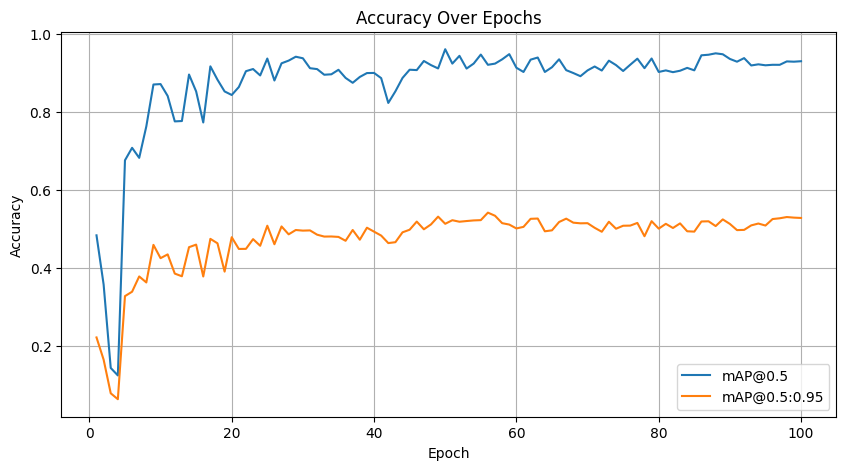

In [26]:
# Most recent train log
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

# Load the results
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

# Extract epochs and accuracy metrics
epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
model.save("best_license_plate_model.pt")

In [38]:
results = model.predict('/kaggle/input/car-plate-detection/images/Cars100.png')


image 1/1 /kaggle/input/car-plate-detection/images/Cars100.png: 224x320 1 license_plate, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 320)


In [39]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'license_plate'}
 obb: None
 orig_img: array([[[ 46,  50,  49],
         [ 47,  52,  51],
         [ 73,  79,  77],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [254, 254, 254]],
 
        [[ 47,  50,  50],
         [ 48,  52,  51],
         [ 54,  59,  58],
         ...,
         [253, 253, 253],
         [254, 254, 254],
         [253, 253, 253]],
 
        [[ 49,  50,  50],
         [ 48,  49,  49],
         [ 50,  52,  51],
         ...,
         [253, 253, 253],
         [254, 254, 254],
         [254, 254, 254]],
 
        ...,
 
        [[ 84,  73,  67],
         [ 85,  74,  68],
         [ 84,  74,  68],
         ...,
         [ 79,  74,  69],
         [ 82,  74,  69],
         [ 82,  72,  67]],
 
        [[ 84,  73,  66],
         [ 85,  74,  67],
         [ 85,  74,  67],
         ...,
         [ 

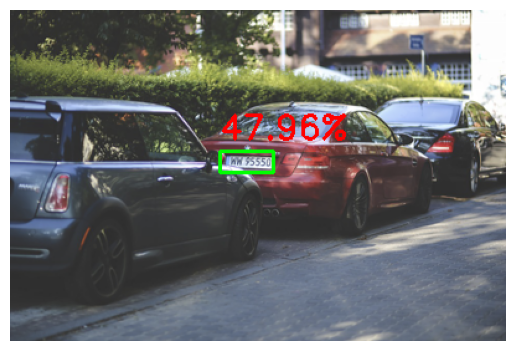

In [62]:
image = cv2.imread('/kaggle/input/car-plate-detection/images/Cars100.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]

            # Draw the bounding box on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
plt.imshow(image)
plt.axis('off')
plt.show()

In [64]:
!pip3 install pytesseract

In [65]:
import pytesseract
from pytesseract import Output


image 1/1 /kaggle/input/car-plate-detection/images/Cars100.png: 224x320 1 license_plate, 9.0ms
Speed: 1.3ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 320)
Detected License Plate Number: WW 75550



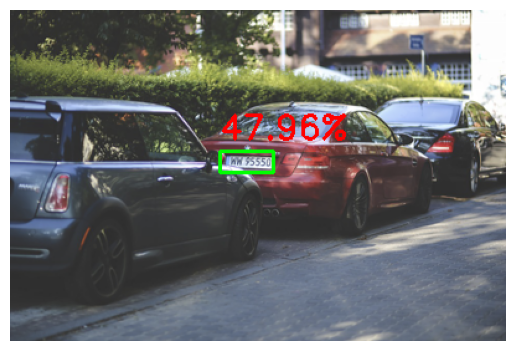

In [66]:
image = cv2.imread('/kaggle/input/car-plate-detection/images/Cars100.png')
results = model.predict('/kaggle/input/car-plate-detection/images/Cars100.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        confidence = box.conf[0]

            # Draw the bounding box on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        
        #ocr
        roi = image[y1:y2 , x1:x2]
        text = pytesseract.image_to_string(roi,config='--psm 6')
        print(f"Detected License Plate Number: {text}")

    # Plot the image with bounding boxes
plt.imshow(image)
plt.axis('off')
plt.show()